In [1]:
import numpy as np
mutated_data = np.load("/content/MUTATION_DATA_TRAINING_6000.npz", allow_pickle=True)
mutated_test = mutated_data['arr_0'][:1000]
output_test = "MUTATED_DATA_TEST_1000_6000"
np.savez_compressed(output_test, arr_0=np.array(mutated_test))
mutated_val = mutated_data['arr_0'][5000:]
output_val = "MUTATED_DATA_VAL_1000_6000"
np.savez_compressed(output_val, arr_0=np.array(mutated_val))
mutated_train = mutated_data['arr_0'][1000:5000]
output_train = "MUTATED_DATA_TRAIN_5000_6000"
np.savez_compressed(output_train, arr_0=np.array(mutated_train))



In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import tensorflow as tf
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from tensorflow.keras import regularizers

def load_sequences(data):
    encoded_sequences = None
    for key in data.files:
        temp_sequences = data[key]
        if temp_sequences.ndim == 2:
            num_samples = temp_sequences.shape[0]
            sequence_length = temp_sequences.shape[1] // 4
            temp_sequences = np.expand_dims(temp_sequences, axis=1)
        if temp_sequences.ndim == 3:
            encoded_sequences = temp_sequences
            break
    return encoded_sequences

def load_sequences_with_shape(data):
    encoded_sequences = None
    for key in data.files:
        temp_sequences = data[key]
        if temp_sequences.ndim == 2:  # If 2D, reshape to 3D for LSTM
            temp_sequences = np.expand_dims(temp_sequences, axis=1)  # (samples, 1, features)
        if temp_sequences.ndim == 3:
            encoded_sequences = temp_sequences
            input_shape = input_shape=(encoded_sequences.shape[1], encoded_sequences.shape[2])
            break
    return encoded_sequences, input_shape
mutated_data = np.load("/content/MUTATION_DATA_TRAINING_6000.npz", allow_pickle=True)
nonmutated_data = np.load("/content/AUGMENTED_DATA_TRAINING_6000_TRUE.npz", allow_pickle=True)

mutated_sequences, shape = load_sequences_with_shape(mutated_data)
nonmutated_sequences, shape = load_sequences_with_shape(nonmutated_data)

mutated_test_1 = np.load("/content/MUTATED_DATA_TEST_1000_6000.npz", allow_pickle=True)
mutated_test = load_sequences(mutated_test_1)
mutated_test_label = np.ones(mutated_test.shape[0])
mutated_test, mutated_test_label = shuffle(mutated_test, mutated_test_label, random_state=42)

mutated_val_1 = np.load("/content/MUTATED_DATA_VAL_1000_6000.npz", allow_pickle=True)
mutated_val = load_sequences(mutated_val_1)
mutated_val_label = np.ones(mutated_val.shape[0])
mutated_val, mutated_val_label = shuffle(mutated_val, mutated_val_label, random_state=42)

mutated_train_1 = np.load("/content/MUTATED_DATA_TRAIN_5000_6000.npz", allow_pickle=True)
mutated_train = load_sequences(mutated_train_1)
mutated_train_label = np.ones(mutated_train.shape[0])
mutated_train, mutated_train_label = shuffle(mutated_train, mutated_train_label, random_state=42)

nonmutated_test_1 = np.load("/content/AUGMENTED_DATA_TEST_1000_6000.npz", allow_pickle=True)
nonmutated_test = load_sequences(nonmutated_test_1)
nonmutated_test_label = np.zeros(nonmutated_test.shape[0])
nonmutated_test, nonmutated_test_label = shuffle(nonmutated_test, nonmutated_test_label, random_state=42)

nonmutated_val_1 = np.load("/content/AUGMENTED_DATA_TEST_VAL_1000_6000.npz", allow_pickle=True)
nonmutated_val = load_sequences(nonmutated_val_1)
nonmutated_val_label = np.zeros(nonmutated_val.shape[0])
nonmutated_val, nonmutated_val_label = shuffle(nonmutated_val, nonmutated_val_label, random_state=42)

nonmutated_train_1 = np.load("/content/AUGMENTED_DATA_TRAIN_5000_6000.npz", allow_pickle=True)
nonmutated_train = load_sequences(nonmutated_train_1)
nonmutated_train_label = np.zeros(nonmutated_train.shape[0])
nonmutated_train, nonmutated_train_label = shuffle(nonmutated_train, nonmutated_train_label, random_state=42)

X_val = np.concatenate([mutated_val, nonmutated_val], axis = 0)
y_val = np.concatenate([mutated_val_label, nonmutated_val_label], axis = 0)
X_val, y_val = shuffle(X_val, y_val, random_state=1)

X_test = np.concatenate([mutated_test, nonmutated_test], axis = 0)
y_test = np.concatenate([mutated_test_label, nonmutated_test_label], axis = 0)
X_test, y_test = shuffle(X_test, y_test, random_state=1)

X_train = np.concatenate([mutated_train, nonmutated_train], axis = 0)
y_train = np.concatenate([mutated_train_label, nonmutated_train_label], axis = 0)
X_train, y_train = shuffle(X_train, y_train, random_state=1)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights for imbalanced dataset
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Print to verify
print("Class Weights:", class_weight_dict)

Class Weights: {0: 1.0, 1: 1.0}


In [ ]:
import seaborn as sns
flat_control_data = nonmutated_val.flatten()
flat_mutated_data = mutated_val.flatten()

# Plotting histograms for comparison
plt.figure(figsize=(12, 6))

# Plot histogram for control data
plt.subplot(1, 2, 1)
sns.histplot(flat_control_data, bins=50, kde=True, color="blue")
plt.title("Control Data (Non-mutated)")
plt.xlabel("Feature Values")
plt.ylabel("Frequency")

# Plot histogram for mutated data
plt.subplot(1, 2, 2)
sns.histplot(flat_mutated_data, bins=50, kde=True, color="red")
plt.title("Mutated Data")
plt.xlabel("Feature Values")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [6]:
from tensorflow.keras.layers import LSTM, GRU, Dropout, Dense, BatchNormalization

In [ ]:
from tensorflow import keras
def rnn_model(input_shape):
    model = Sequential([

        # First LSTM Layer
        LSTM(128, input_shape=input_shape, return_sequences=True, activation="relu"),  # Reduced L2 regularization strength


        # Second LSTM Layer
        LSTM(64, activation="relu", return_sequences=True),  # Reduced L2 regularization strength

        # Third LSTM Layer
        LSTM(32, activation="relu", return_sequences=False),  # Reduced L2 regularization strength

        Dense(1, activation="relu"),  # Smaller dense layer

        Dropout(0.4),        # Output Layer
        Dense(1, activation="sigmoid", kernel_regularizer=keras.regularizers.L2(0.01))  # Output layer with L2
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])
    return model
def reset_rnn(input_shape):
    # Recreate the model to reset weights
    model = rnn_model(input_shape)
    return model

# Train the model
checkpoint_path = "E:/my_models/6000_2_if_new_best_model.weights.h5"

model1 = reset_rnn(shape)
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True, verbose=1)
csv_logger = CSVLogger("training_log_6000_2.csv")

history = model1.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100, batch_size=32, callbacks=[checkpoint, csv_logger])


# Evaluate the model
y_pred = model1.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Evaluate model performance
print(classification_report(y_test, y_pred_classes))
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.5f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

# Test Accuracy
loss, accuracy = model1.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Predictions
predictions = model1.predict(X_test).flatten()
print("\n🔹 First 10 Predictions vs Actual Values 🔹")
for i in range(10):
    print(f"Sample {i+1}: Actual = {y_test[i]}, Predicted Probability = {predictions[i]:.4f}")

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7482 - loss: 0.5095
Epoch 1: val_loss improved from inf to 0.34259, saving model to E:/my_models/6000_2_if_new_best_model.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.7483 - loss: 0.5094 - val_accuracy: 1.0000 - val_loss: 0.3426
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7974 - loss: 0.4838
Epoch 2: val_loss improved from 0.34259 to 0.33666, saving model to E:/my_models/6000_2_if_new_best_model.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.7974 - loss: 0.4837 - val_accuracy: 1.0000 - val_loss: 0.3367
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8117 - loss: 0.4715
Epoch 3: val_loss improved from 0.33666 to 0.33115, saving model to E:/my_models/6000_2_if_new_best_model.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - accuracy: 0.8117 - loss: 0.4715 - val_accuracy: 1.0000 - val_loss: 0.3311
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 

In [43]:
model1.summary()

# Check regularizers applied to each layer:
for layer in model1.layers:
    if hasattr(layer, 'kernel_regularizer') and layer.kernel_regularizer is not None:
        print(f"Layer {layer.name} has regularizer: {layer.kernel_regularizer}")


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_85 (LSTM)                       │ (None, 1, 32)               │      52,484,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_86 (LSTM)                       │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,462,517 (600.67 MB)

 Trainable params: 52,487,505 (200.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 104,975,012 (400.45 MB)

Layer lstm_85 has regularizer: <keras.src.regularizers.regularizers.L2 object at 0x7e449a6c7d60>
Layer lstm_86 has regularizer: <keras.src.regularizers.regularizers.L2 object at 0x7e43949bfca0>
Layer dense_56 has regularizer: <keras.src.regularizers.regularizers.L2 object at 0x7e47270e7340>
Layer dense_57 has regularizer: <keras.src.regularizers.regularizers.L2 object at 0x7e4779f0e8f0>


63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.9570 - loss: 0.5494
Test Accuracy: 0.9605
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96      1000
         1.0       1.00      0.92      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000

ROC-AUC: 0.9259999999999999


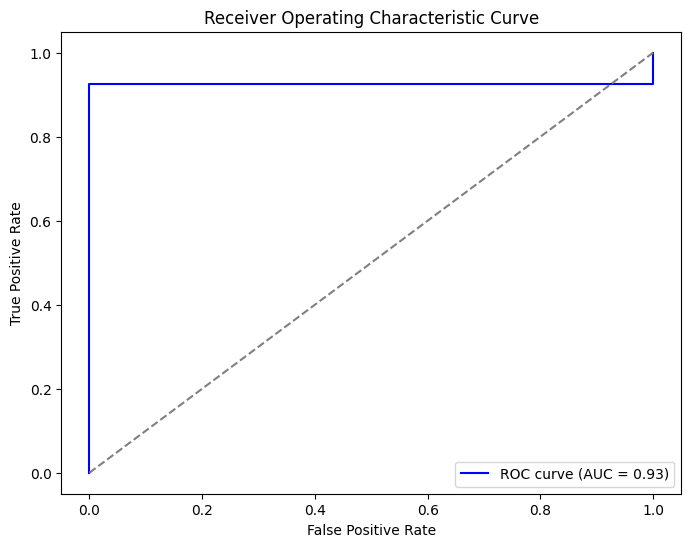

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.9570 - loss: 0.5494
Test Accuracy: 0.9605
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step

🔹 First 10 Predictions vs Actual Values 🔹
Sample 1: Actual = 1.0, Predicted Probability = 0.9999
Sample 2: Actual = 0.0, Predicted Probability = 0.4761
Sample 3: Actual = 0.0, Predicted Probability = 0.4745
Sample 4: Actual = 0.0, Predicted Probability = 0.4782
Sample 5: Actual = 0.0, Predicted Probability = 0.4761
Sample 6: Actual = 0.0, Predicted Probability = 0.4762
Sample 7: Actual = 1.0, Predicted Probability = 0.9999
Sample 8: Actual = 1.0, Predicted Probability = 0.9999
Sample 9: Actual = 0.0, Predicted Probability = 0.4736
Sample 10: Actual = 1.0, Predicted Probability = 0.5124


In [36]:
loss, accuracy = model1.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
y_pred = model1.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Evaluate model performance
print(classification_report(y_test, y_pred_classes))
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

# Test Accuracy
loss, accuracy = model1.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Predictions
predictions = model1.predict(X_test).flatten()
print("\n🔹 First 10 Predictions vs Actual Values 🔹")
for i in range(10):
    print(f"Sample {i+1}: Actual = {y_test[i]}, Predicted Probability = {predictions[i]:.4f}")

In [ ]:
import shap
explainer = shap.Explainer(model, X_train)
explainer = shap.GradientExplainer(model, X_train_combined[:100])
# Calculate SHAP values for the input data
shap_values = explainer(X_train)






KeyboardInterrupt: 

In [ ]:
shap.summary_plot(shap_values, input_data)

In [ ]:
shap.initjs()  # Initialize JavaScript visualization
shap.force_plot(shap_values[0], input_data[0]

In [ ]:
shap.dependence_plot("feature_name", shap_values, input_data)

In [ ]:
shap.waterfall_plot(shap_values[0])